In [1]:
import sys
print(sys.version)

3.7.2 (default, Dec 29 2018, 06:19:36) 
[GCC 7.3.0]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [3]:
class BernoulliBanditEnv(object): 
    # Clase que define el environment donde el reward es 0 o 1 dependiendo de una probabilidad p.

    def __init__(self, num_arms=10, p=None):
        self.num_arms = num_arms
        self.actions = np.arange(num_arms)     # define set of actions

        if len(p)==1:
            self.p = np.random.beta(0.5, 0.5, size=num_arms)
        elif len(p) == num_arms:
            self.p = p
        else:
            raise Exception('Number of probabilities ({}) does not correspond to number of arms ({}).'.format(len(q), num_arms))
        self.best_action = np.argmax(self.p)   # La mejor accion dado el enviroenmenteneas

    def reward(self, action):
        return np.random.binomial(1, p=self.p[action])


In [106]:
class Agent(object):
    # Clase que define al agente. Cada agente cuenta con una regla de decisión y una regla de aprendizaje.
    
    def __init__(self, learning_rule, decision_rule, param=None):
        self.decision_rule = decision_rule
        self.learning_rule = learning_rule

        if decision_rule == "epsilon-greedy":
            self.epsilon = param["epsilon"]
        
        if decision_rule == "UCB":
            self.UCB_param = param["UCB_param"]
        
        if decision_rule == "gradient":
            self.lr = param["lr"]
    
    def environment(self, env, init_q):
        # inicializa el environment
        self.env = env                                  
        self.k = env.num_arms                           
        self.actions = np.arange(self.k)                
        self.act_count = np.zeros(self.k)               
        self.iteration = 0     
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha = np.random.uniform(size=self.k)
            self.beta  = np.random.uniform(size=self.k)
        if len(init_q) == self.k:
            self.q_estimate = init_q
        else:
            raise Exception('Number of initial values ({}) does not correspond to number of arms ({}).'.format(len(init_q), self.k))

    def learn(self, a, r):
        # Guardo last_reward para el gradient bandits
        if self.decision_rule == "gradient":
            self.last_action = a
            self.last_reward = r
        
        # dada una acción y una recompenza, actualiza la value function.
        if self.learning_rule == "averaging":
            #OBS
            # Al comienzo de cada episodio, self.q_estimate[a] se setea a 0 o 1 segun
            # el si obtiene reward. a es random la primera vez en gradient, y si elije
            # random action no optima, y recibe premio, setea ese q value a 1
            self.q_estimate[a] += 1/self.act_count[a] * (r - self.q_estimate[a])
            
#             print("self.act_count[",a,"]: ", self.act_count[a] )
#             print("self.q_estimate after update: ", self.q_estimate )
#             print("1/self.act_count[a] * (r - self.q_estimate[a]")
#             print("1/",self.act_count[a]," * (", r, " - ", self.q_estimate[a])
            #self.init_q = self.q_estimate
            
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha[a] += r
            self.beta[a]  += 1 - r 
            
    def act(self):
        # realiza una acción.
        self.iteration += 1 
        
        if self.decision_rule == "greedy":
            selected_action = greedyAction(self.q_estimate)
            pass
        if self.decision_rule == "epsilon-greedy":
            selected_action = epsilonGreedyAction(self.q_estimate, self.epsilon)
            pass
        if self.decision_rule == "UCB":
            selected_action = upperConfidenceBoundAction(self.q_estimate, self.UCB_param, self.iteration, self.act_count)
            pass
        if self.decision_rule == "gradient":
            # Tomar H (self.pref) como mi funcion de preferencia que actualiza cuando compara
            # el reward R que obtuve con mi reward promedio estimado R^
            # Debo actualizar dos cosas:
            #    la preferencia de la accion que tome (aumenta o disminuye)
            #    la preferencia de las otras acciones (disminuyen o aumentan)
            if self.iteration == 1:
                # First action decision, without having rewards, so
                # equal preferences for each action
                self.pref = np.empty(self.k)
                #self.pref.fill(0)#1.0/self.k)
                self.pref = softmax_vect(self.q_estimate)
            else:
                pi = softmax_vect(self.pref)
                # Obs: uso q_estimate como promedio de rewards, ya que acumula llevando la cuenta
                
                r_diff = self.last_reward - self.q_estimate[self.last_action]
#                 if self.iteration == 2:
#                     print("it.2 - r_diff: ", r_diff)
                # one-hot vector with chosen last action
                indicactor = np.where(self.actions==self.last_action, np.ones(self.k), 0.0)
                self.pref += self.lr * r_diff * (indicactor-pi)
            pi = softmax_vect(self.pref)
            selected_action = np.random.choice(self.actions, p=pi)
#             if self.iteration == 2:
#                 print("it.2 - self.pref: ", self.pref,
#                           " - pi: ", pi,
#                           " - selected action: ", selected_action)
            # set Verbose = True
            # to print 'c' consecutives values every 'every' values:
            verbose = False
            c = 10
            every = 100
            if verbose and np.any(np.mod(c*[self.iteration], c*[every]) == np.arange(2,2+c)):
                print(self.iteration,"\t" , np.around(self.pref, 4),"  \t", np.around(pi, 3),"\t", 
                  "a_t+1:"+str(selected_action),"\t" , "a:"+str(self.last_action), 
                  "r:"+str(self.last_reward), "d:"+str(np.around(r_diff, 3)),"\t" , indicactor, np.around(self.q_estimate, 3))
            #pass
        if self.decision_rule == "Thompson":
            # COMPLETAR
            pass
        # Intento mantener q_estimate entre repes
        #self.init_q = self.q_estimate
        #print(self.init_q)
        self.act_count[selected_action] += 1
        return selected_action

In [107]:
test = np.empty(2)
test.fill(0)
pi2 = softmax_vect(test)
indicactor2 = np.array([1,0])
test += 0.1*0.5*(indicactor2-pi2)
print("0.1 * 0.5 *(",indicactor2, "-", pi2, ") =", test)

0.1 * 0.5 *( [1 0] - [0.5 0.5] ) = [ 0.025 -0.025]


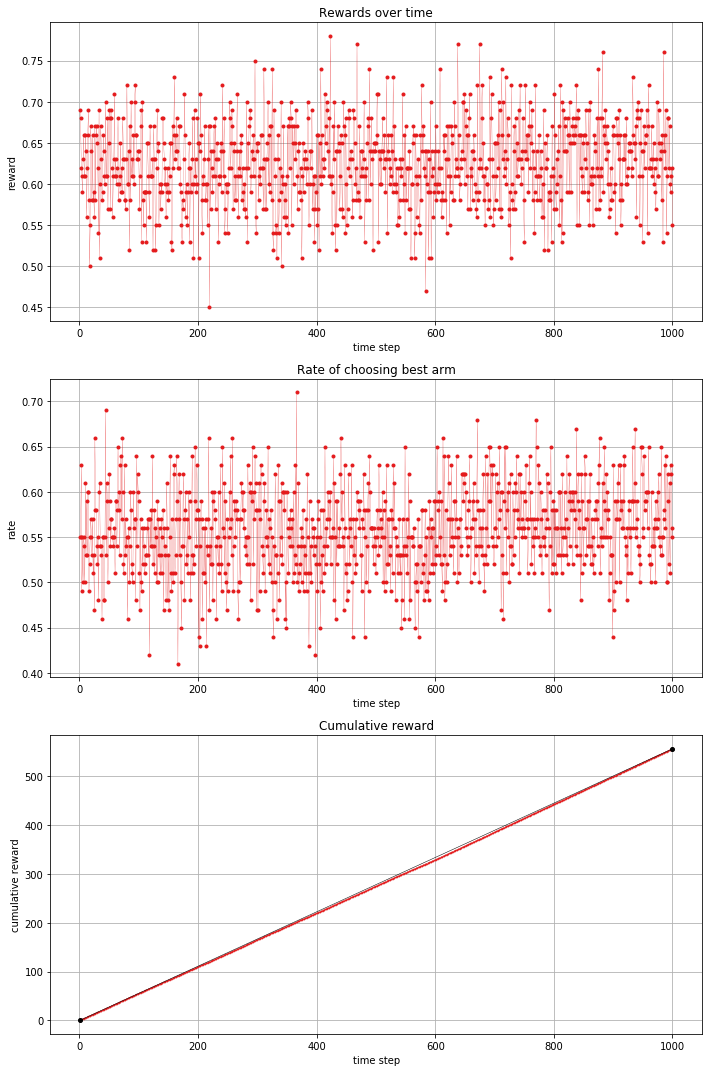

In [108]:
# Run all function definition cells before this one!
#
# Gradient Experiment
params = {"lr": 0.1}
agent = Agent("averaging", "gradient", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)
#it [ H preferences ] [ softmax probs ]  sel.action last.action last.reward r_diff indicactor q_estimate initq

In [90]:
1+1*(5==5)

2

In [8]:
def greedyAction(q_estimate):
    # Choose greedly one of the best actions
    return randomArgmax(q_estimate)

def epsilonGreedyAction(q_estimate, eps):
    # Greedy action with prob p=1-eps, random with prob eps=1-p
    if np.random.choice([True, False], p=[1-eps, eps]):
        # Greedy action
        return greedyAction(q_estimate)
    else:
        # Random action
        return np.random.choice(np.arange(len(q_estimate)))

def upperConfidenceBoundAction(q_estimate, c, iteration, act_count):
    # De Sutton:
    # "if action a was never chosen > a is a maximizing action"
    # NO quiero que las acciones jamas elegidas 'me pisen' acciones con
    # pesos fuertes por tener peso infinito al dividir por cero.
    uncertainty = np.sqrt(np.log(iteration)/np.maximum(1, act_count))
    # Con 'maximizing action' de Sutton, elijo su valor a partir del maximo de las
    # acciones ya elegidas.
    # ie: Las acciones no elegidas tienen EL MISMO valor que LA MEJOR accion elegida hasta el momento,
    #     de esa forma evito que solo elija acciones NO tomadas hasta que las tome todas.
    # 1. q_estimate + uncertainty para acciones ya elegidas (ignoro las NO elegidas)
    part_candidates = q_estimate + c*np.where(act_count>0, uncertainty, 0)
    # 2. le doy el max puntaje (de q_estimate) a las acciones NO elegidas
    candidates = np.where(act_count>0, part_candidates, np.amax(part_candidates))
    return randomArgmax(candidates)

def gradientAction():
    pass

In [9]:
def randomArgmax(v):
    """Like np.argmax(), but if there are several "best" actions,
       chooses and returns one randomly"""
    arguments = np.argwhere(v == np.amax(v)).ravel()
    arg = np.random.choice(arguments)
    return arg

def softmax_vect(v):
    """Returns a vector with all softmax values"""
    exp_vect = np.exp(v)
    return exp_vect/np.sum(exp_vect)

## Gradient Bandits

Gradient bandits actualiza la preferencia de cada accion deacuerdo a 
la diferencia entre el reward obtenido y el promedio

<img src="img/gradient-bandits.png" width="500" align="left" />

In [44]:
def simulateBandits(agents, narms, initp=None, initq=None, repetitions=1000, N=100):
    # función que realiza las simulaciones de los agentes. Se define el número de repeticiones que seran
    #  promediadas y el número de pasos N. agents es una lista de agentes.
    rewards = np.zeros((len(agents), repetitions, N))
    bestarm = np.zeros((len(agents), repetitions, N))
    for i, agent in enumerate(agents):
        for j in np.arange(repetitions):
            environment = BernoulliBanditEnv(num_arms=narms, p=initp)
            # Intento mantener q_estimate entre repeticiones
            #print(initq)
            agent.environment(environment, initq if not(np.array_equal(initq, None)) else np.zeros(narms))
            #print(initq)
            for n in np.arange(N):
                a = agent.act()
                r = environment.reward(a)
                agent.learn(a, r)
                rewards[i, j, n] = r
                bestarm[i, j, n] = 1 if a == environment.best_action else 0
    
    return np.squeeze(np.mean(rewards, axis=1)), np.squeeze(np.mean(bestarm, axis=1))

### up

In [148]:
def plot_results(agents, actions, rewards):
    # Simulates and plot data
    # Number of steps to play
    N = 1000
    # We play for 'N' steps, then repeat for 'reps' times, and take the mean
    reps = 100
    # Necesary for initq to be an array to be improved over iterations
    initq = np.zeros(actions)
    # Generating data
    total_data = np.asarray(simulateBandits(agents, narms=actions, initp=rewards, initq=initq, repetitions=reps, N=N))
    # data shape: (rewards, agents, time step)
    if len(agents)==1:
        # reshaping as several actor data, so it matches dimensions
        total_data = total_data.reshape(2,1,N)
    # Defining plots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
    # Subplot 1: Rewards over time
    ax1.set_title("Rewards over time")
    ax1.set_xlabel("time step")
    ax1.set_ylabel("reward")
    ax1.grid()
    # Subplot 2: Agent's rate of choosing best arm
    ax2.set_title("Rate of choosing best arm")
    ax2.set_xlabel("time step")
    ax2.set_ylabel("rate")
    ax2.grid()
    # Subplot 3: Cumulative reward
    ax3.set_title("Cumulative reward")
    ax3.set_xlabel("time step")
    ax3.set_ylabel("cumulative reward")
    ax3.grid()
    time_steps = np.arange(1, N+1)
    # Doing fancy stuff with colors
    colors=iter(cm.Set1(np.linspace(0,1,len(agents))))
    # looping over individual agent data
    for a in range(total_data.shape[-2]):
        # data from each agent
        data = total_data[:,a,:]
        # Subplot 1: Rewards over time
        #ax1.plot(time_steps, data[0,:], 'r.-', label="reward-actor-"+str(a), linewidth=0.2)
        color = next(colors)
        ax1.plot(time_steps, data[0,:], marker=".", linestyle='-', linewidth=0.2,
                 color=color, label="reward-actor-"+str(a+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        # Subplot 2: Agent's rate of choosing best arm
        ax2.plot(time_steps, data[1,:], marker=".", linestyle='-', linewidth=0.2,
                 color=color, label="best-arm-actor-"+str(a+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        # Subplot 3: Cumulative reward
        ax3.plot(time_steps, np.cumsum(data[1,:]), marker=".", markersize=1, linestyle='-', linewidth=0.5,
                 color=color,
                 label="cumulative-actor-"+str(a+1))
        # black straight line from first to last value to see curvatures
        ax3.plot([time_steps[0], time_steps[-1]],
                 [np.cumsum(data[1,:])[0], np.cumsum(data[1,:])[-1]],
                 'ko-', label="straight-line-"+str(a), markersize=4, linewidth=0.5)
        ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

[go down](#down)

# Ejercicios:

1. Completar pertinentemente el código donde diga "COMPLETAR".

[2.](#Bandits-de-2-brazos) Realizar simulaciones con un bandit de 2 brazos (P = [0.4, 0.8]) para cada una de las reglas de decisión y graficar la recompensa promedio, la recompensa acumulada y el porcentaje de veces que fue elegido el mejor brazo en función de los pasos. Interprete los resultados.

[3.](#Bandits-de-10-brazos) Realizar simulaciones con un bandit de 10 brazos (P = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) para cada una de las reglas de decisión y graficar la recompensa promedio, la recompensa acumulada y el porcentaje de veces que fue elegido el mejor brazo en función de los pasos. Interprete los resultados.

[4.](#Estudio-de-Epsilon-Greedy) Estudie la dependencia del hiperparametro epsilon en la regla de decisión **epsilon-greedy**.


# 1. Completar

#### Hecho en celdas superiores

# 2. Bandits de 2 brazos

### Greedy

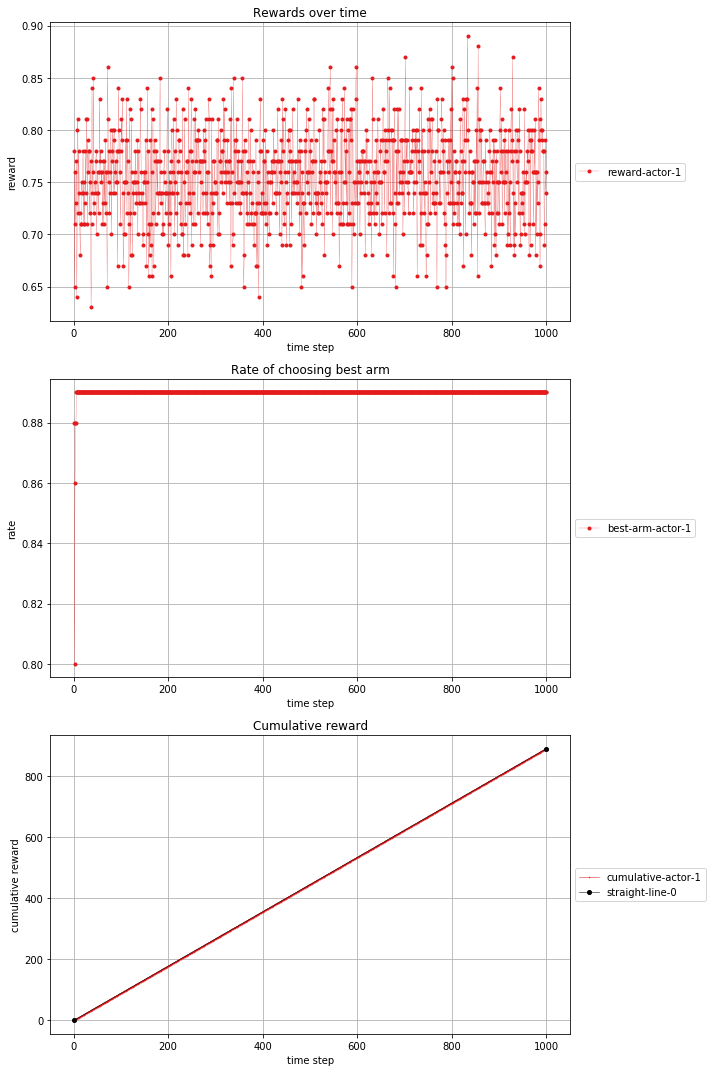

In [135]:
agent = Agent("averaging", "greedy")
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Epsilon-Greedy

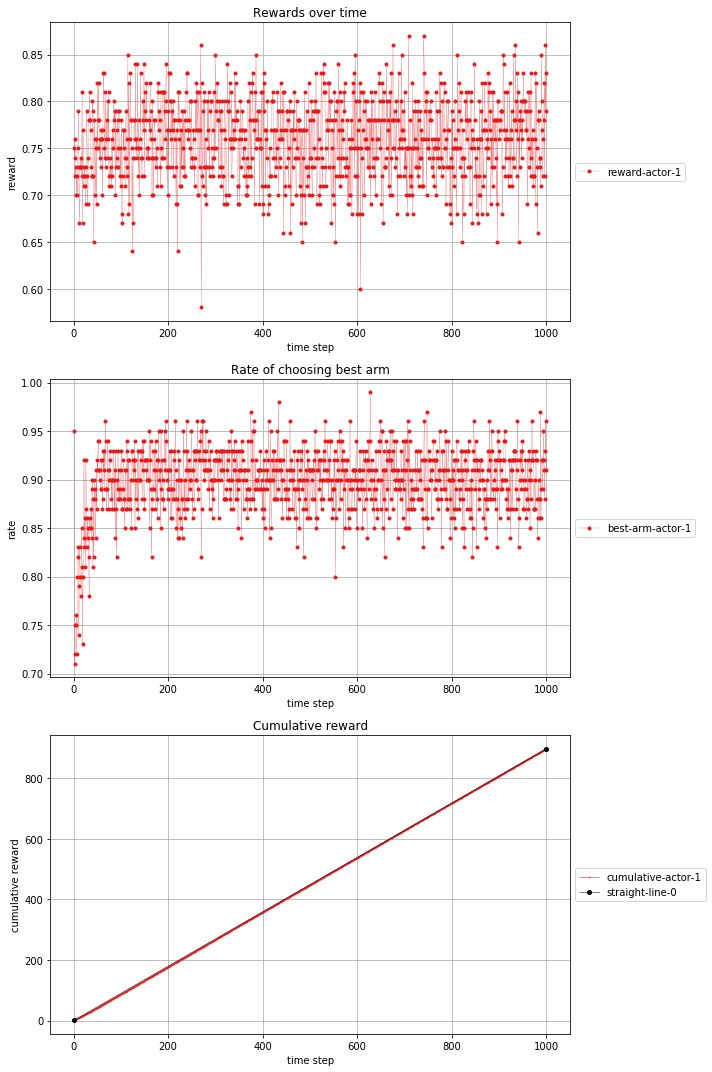

In [136]:
params = {"epsilon": 0.2}
agent = Agent("averaging", "epsilon-greedy", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### UCB

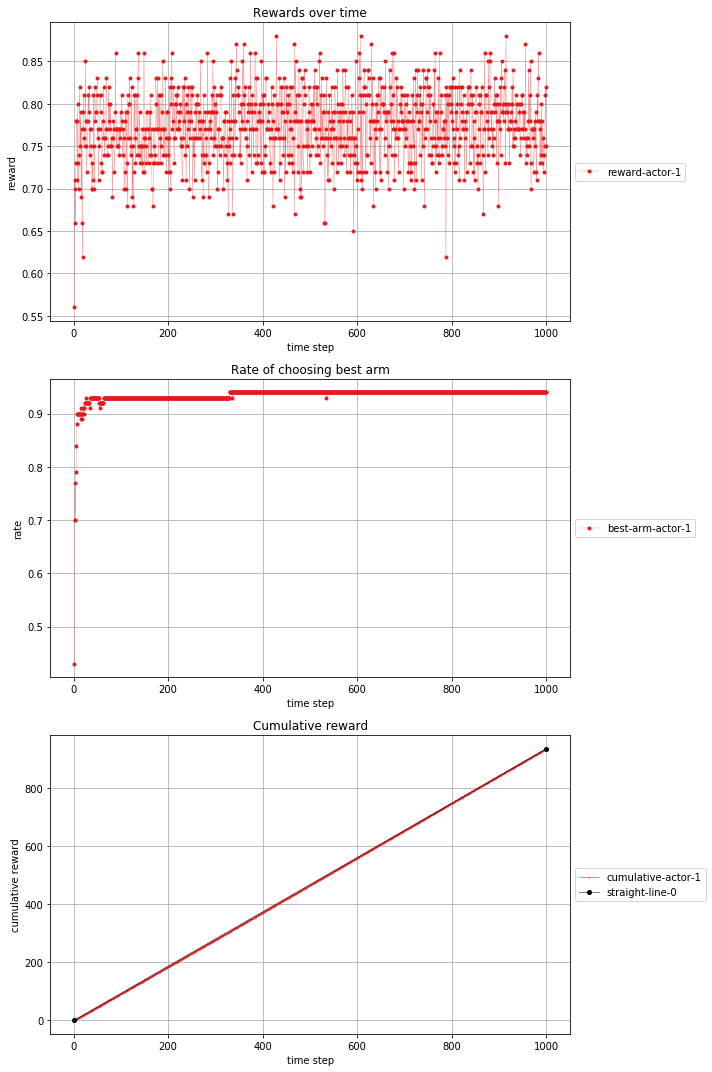

In [137]:
params = {"UCB_param": 0.1}
agent = Agent("averaging", "UCB", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Gradient

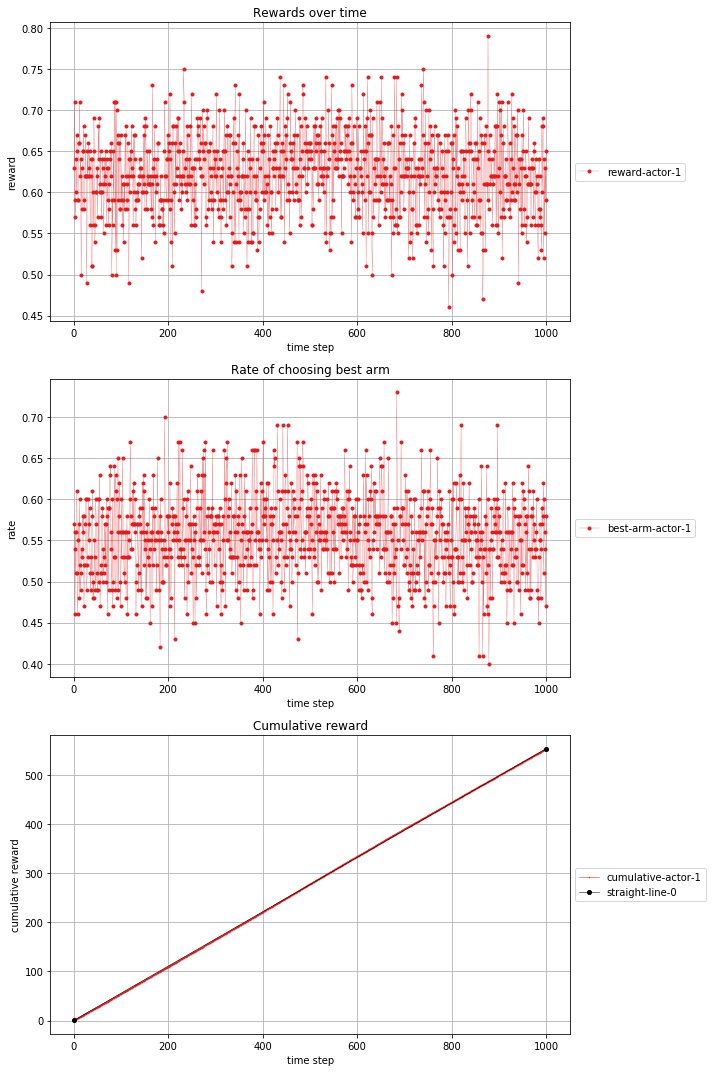

In [138]:
params = {"lr": 0.05}
agent = Agent("averaging", "gradient", params)
agents = np.array([agent])
initp = np.array([0.4, 0.8]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

# 3. Bandits de 10 brazos

#### Greedy

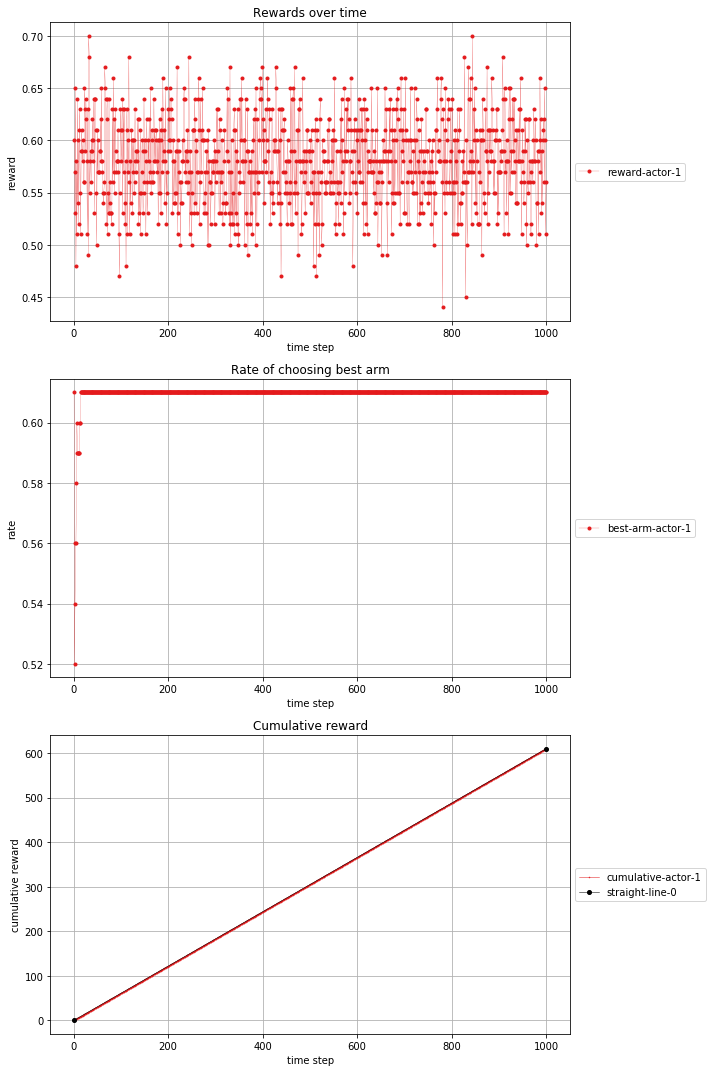

In [139]:
agent = Agent("averaging", "greedy")
agents = np.array([agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Epsilon-Greedy

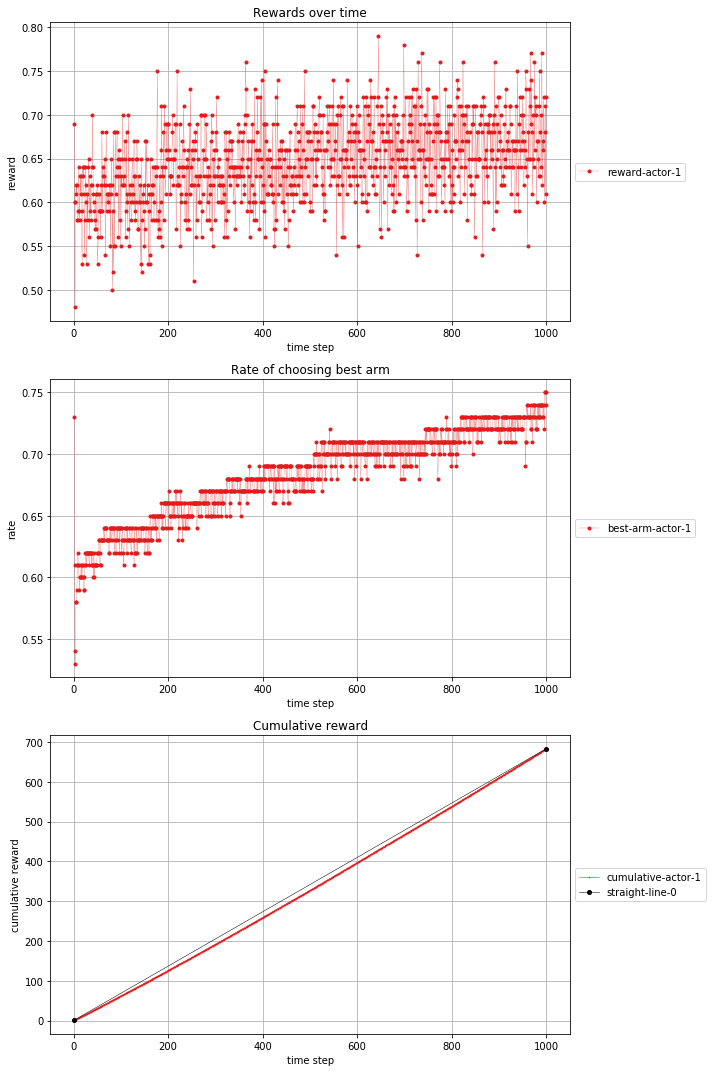

In [140]:
params = {"epsilon": 0.01}
agent = Agent("averaging", "epsilon-greedy", params)
agents = np.array([agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### UCB

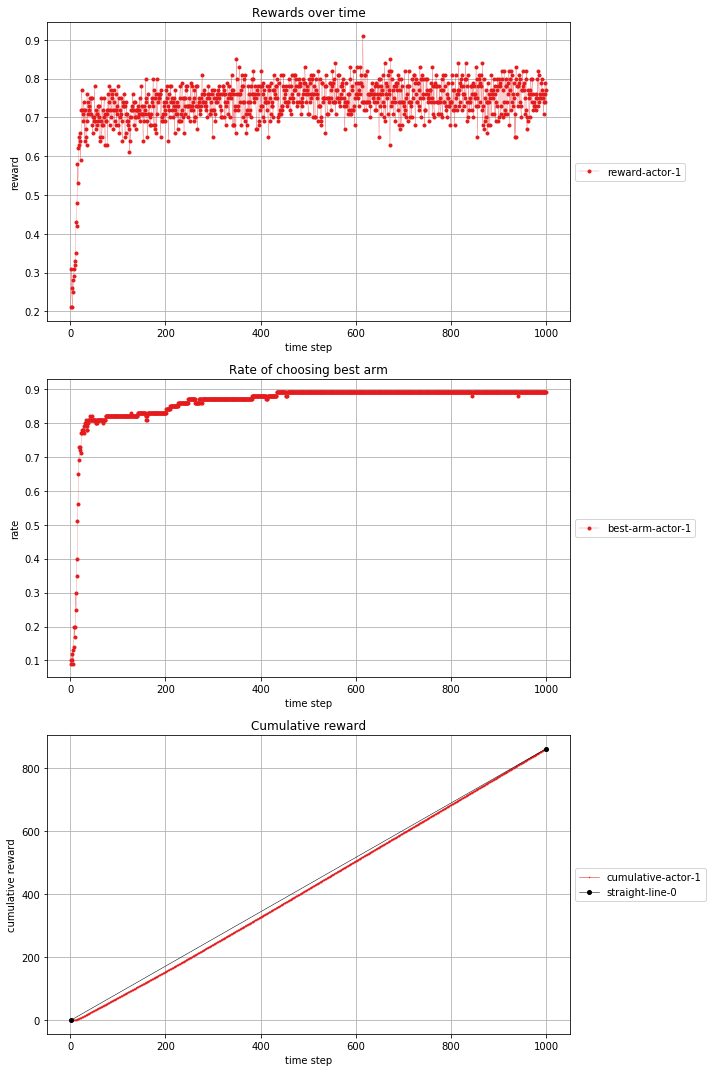

In [141]:
params = {"UCB_param": 0.1}
agent = Agent("averaging", "UCB", params)
agents = np.array([agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

### Gradient

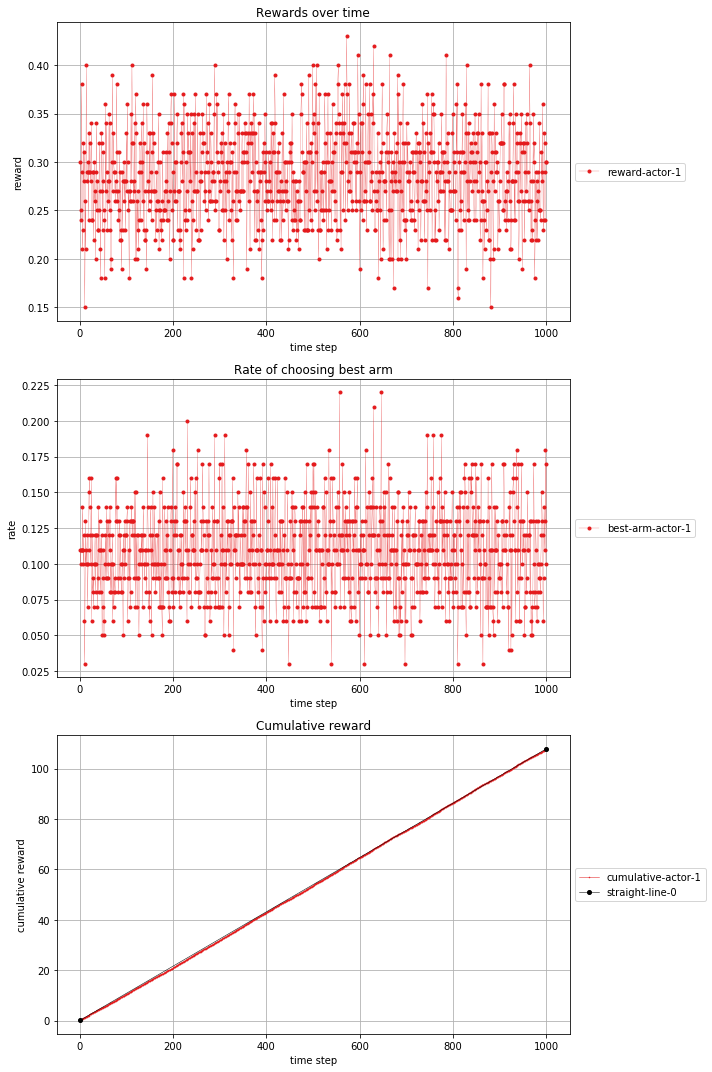

In [142]:
params = {"lr": 0.01}
agent = Agent("averaging", "gradient", params)
agents = np.array([agent])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

## Experimenting with several agent data on same plot

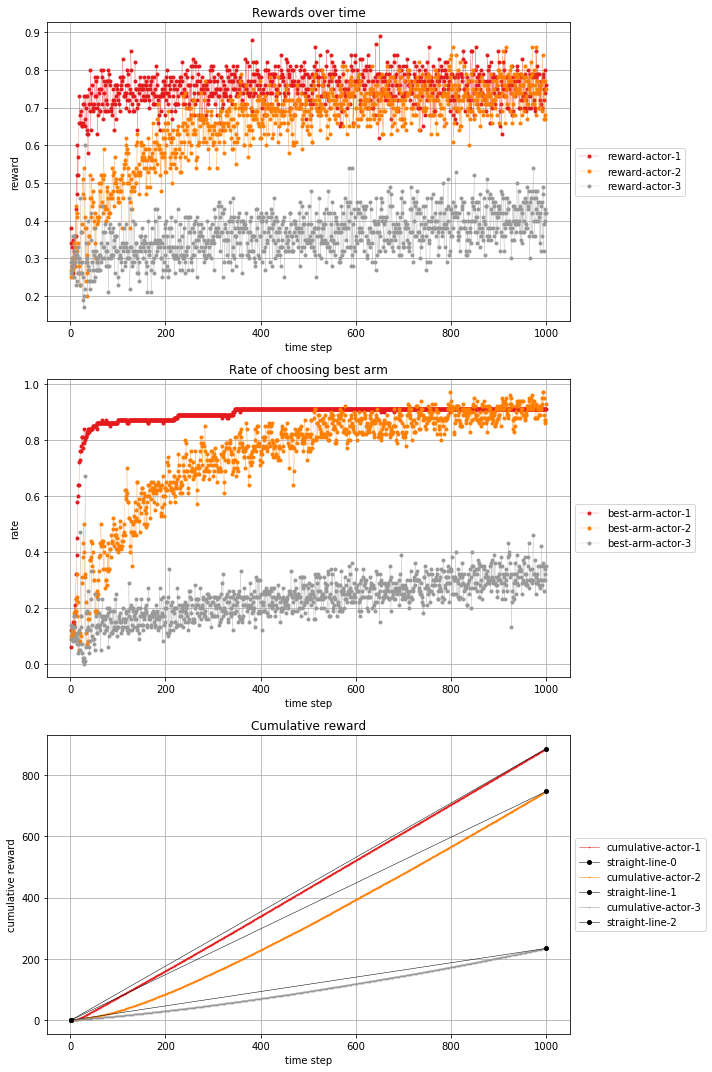

In [143]:
params1 = {"UCB_param": 0.1}
agent1 = Agent("averaging", "UCB", params1)
params2 = {"UCB_param": 1.4}
agent2 = Agent("averaging", "UCB", params2)
params3 = {"UCB_param": 5}
agent3 = Agent("averaging", "UCB", params3)
#
agents = np.array([agent1, agent2, agent3])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)

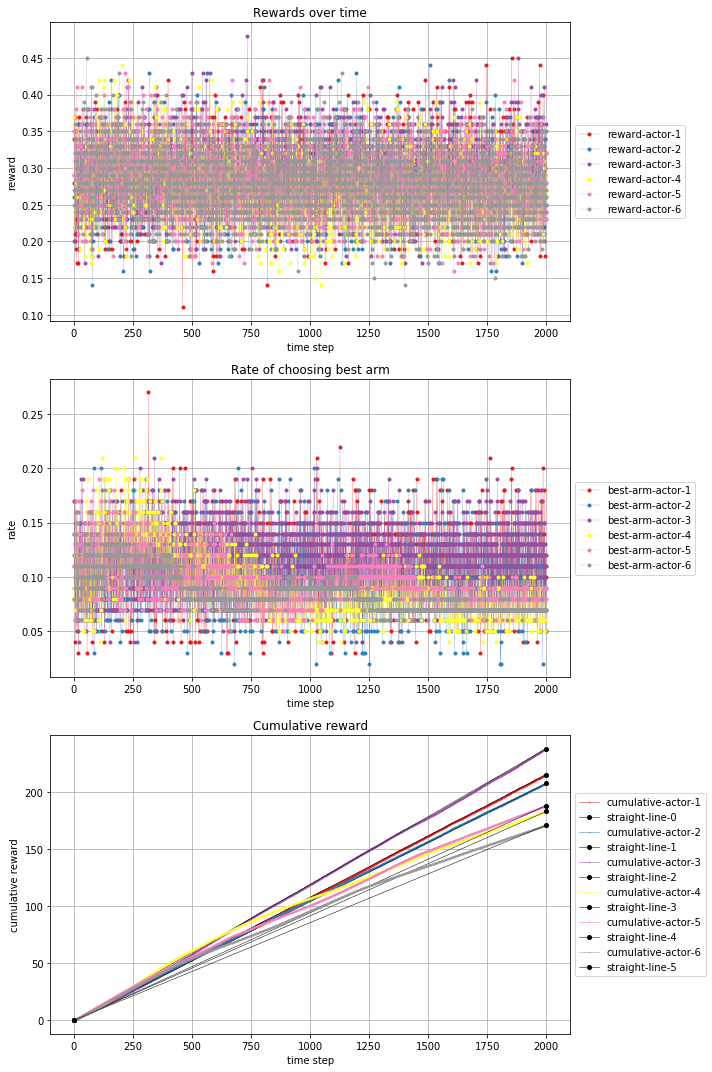

In [147]:
# Gradient Experiment
params1 = {"lr": 0.03}
agent1 = Agent("averaging", "gradient", params1)
params2 = {"lr": 0.1}
agent2 = Agent("averaging", "gradient", params2)
params3 = {"lr": 0.3}
agent3 = Agent("averaging", "gradient", params3)
params4 = {"lr": 0.7}
agent4 = Agent("averaging", "gradient", params4)
params5 = {"lr": 1}
agent5 = Agent("averaging", "gradient", params5)
params6 = {"lr": 3}
agent6 = Agent("averaging", "gradient", params6)
#
agents = np.array([agent1, agent2, agent3, agent4, agent5, agent6])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)
#it [ H preferences ] [ softmax probs ]  sel.action last.action last.reward r_diff 

# down

[go up](#up)

# 4. Estudio de Epsilon-Greedy
#### y la dependencia de epsilon en la regla de decisión

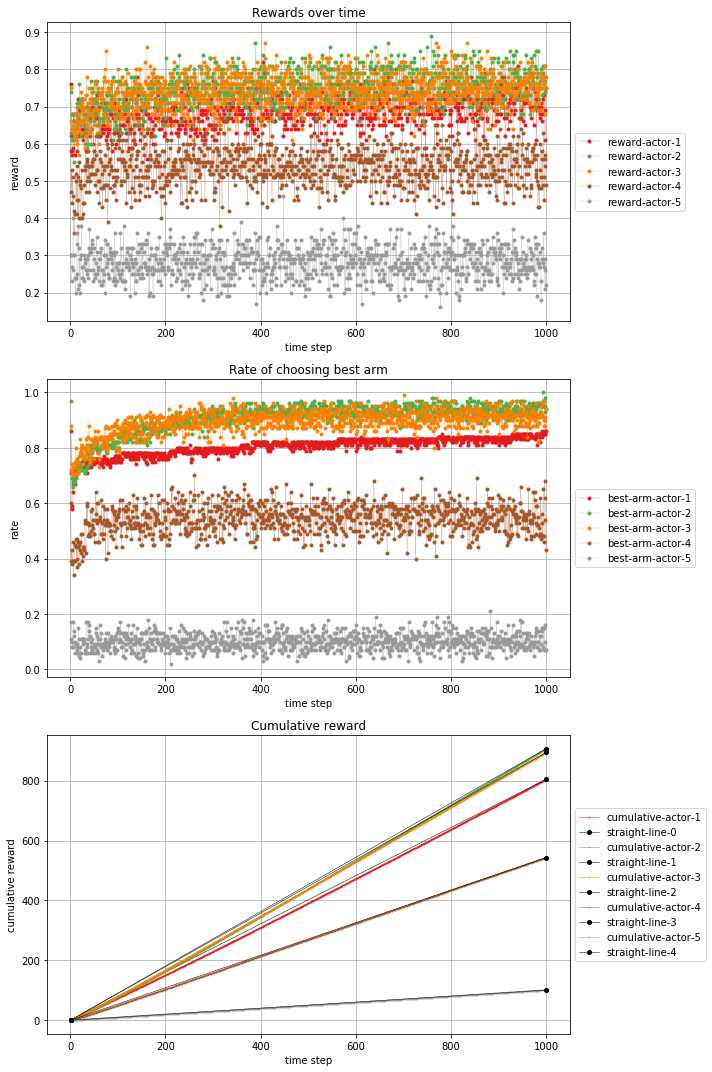

In [149]:
params1 = {"epsilon": 0.01}
agent1 = Agent("averaging", "epsilon-greedy", params1)
params2 = {"epsilon": 0.05}
agent2 = Agent("averaging", "epsilon-greedy", params2)
params3 = {"epsilon": 0.1}
agent3 = Agent("averaging", "epsilon-greedy", params3)
params4 = {"epsilon": 0.5}
agent4 = Agent("averaging", "epsilon-greedy", params4)
params5 = {"epsilon": 1}
agent5 = Agent("averaging", "epsilon-greedy", params5)
agents = np.array([agent1, agent2, agent3, agent4, agent5])
initp = np.array([0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]) #prob of each arm of giving reward
narms = len(initp)
initq = np.zeros(narms)
plot_results(agents, actions=narms, rewards=initp)